(1455, 268)
(1455,)
(1459, 268)
(1455, 1, 268)
# Neural Network with 54001 learnable parameters

## Layer information

  #  name    size
---  ------  ------
  0  input   1x268
  1  hidden  200
  2  output  1

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1   118.05998    50.54718    2.33564  0.02s
      2    21.41522     1.70801   12.53812  0.02s
      3     0.42707     0.31643    1.34962  0.02s
      4     0.28801     0.23045    1.24982  0.02s
      5     0.17149     0.16878    1.01603  0.02s
      6     0.11786     0.09479    1.24337  0.02s
      7     0.07866     0.07437    1.05765  0.02s
      8     0.06522     0.06424    1.01523  0.02s
      9     0.05562     0.05730    0.97067  0.02s
     10     0.04883     0.05120    0.95382  0.02s
     11     0.04373     0.04668    0.93673  0.02s
     12     0.03986     0.04340    0.91849  0.02s
     13     0.03677     0.04080    0.90100  0.02s
     14     0.03423     0.03862    0.88616 

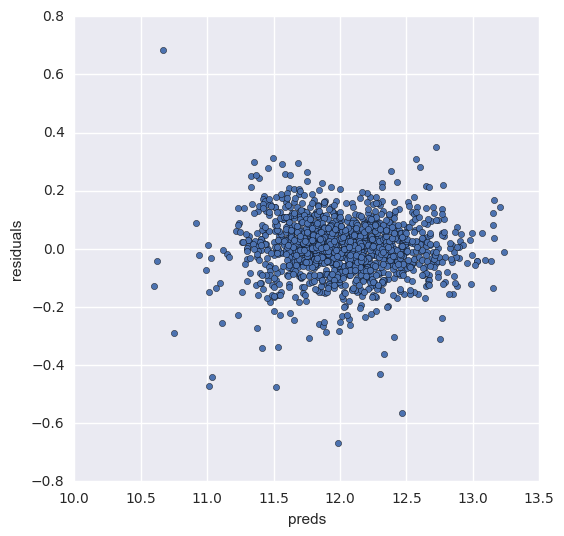

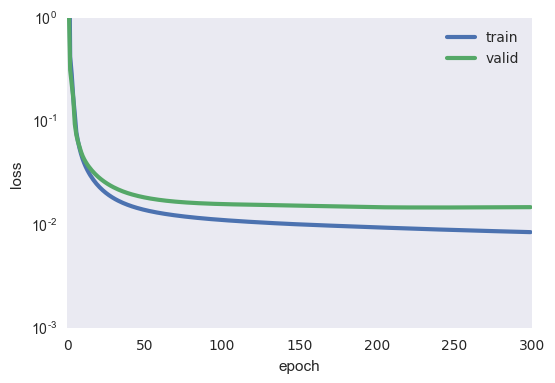

In [126]:
# %load nn.py
import numpy
import numpy as np
import theano
import pandas as pd
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from load_data import load
from sklearn import preprocessing
from lasagne.layers import get_output


def rmse_cv(model,cv=5):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = cv))
    return rmse

def load_nn():
    X, y, X_submission, Id = load()
    INPUT_DIM = X.shape[1]
    X = X.values.astype(numpy.float32)
    y = y.values.astype(numpy.float32)
    X_submission = X_submission.values.astype(numpy.float32)
    y = y.reshape(-1,1)
    X = preprocessing.MinMaxScaler().fit_transform(X)
    X_submission = preprocessing.MinMaxScaler().fit_transform(X_submission)

    X = X.reshape(-1,1,INPUT_DIM)
    X_submission = X_submission.reshape(-1,1,INPUT_DIM)
    return X, y, X_submission, Id, INPUT_DIM

X, y, X_submission, Id, INPUT_DIM = load_nn()

print X.shape

def float32(k):
    return np.cast['float32'](k)

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = np.cast['float32'](self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()


# not working
net2 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('conv1', layers.Conv1DLayer),
        ('pool1', layers.MaxPool1DLayer),
        ('dropout1', layers.DropoutLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    
    # layer parameters:
    input_shape=(None,1, INPUT_DIM),  # 410 input features per batch
    conv1_num_filters=10, conv1_filter_size=3,
    pool1_pool_size=2,
    dropout1_p=0.1,  # !

    hidden_num_units=500,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=1,  # 30 target values

    update_learning_rate=theano.shared(float32(0.01)),
    update_momentum=theano.shared(float32(0.9)),

    # optimization method:
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.003, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=100),
        ],

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=700,  # we want to train this many epochs
    verbose=1,
    )

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    # layer parameters:
    input_shape=(None,1, INPUT_DIM),  # 410 input features per batch
    hidden_num_units=200,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=1,  # 1 target values

    update_learning_rate=theano.shared(float32(0.01)),
    update_momentum=theano.shared(float32(0.9)),

    # optimization method:
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.007, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=100),
        ],

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=300,  # we want to train this many epochs
    verbose=1,
    )


net1.fit(X, y)
preds = net1.predict(X_submission) 





y_submission = numpy.expm1(preds).flatten()
print y_submission.shape
print y_submission

# computing training error
from sklearn.metrics import mean_squared_error
train_preds = net1.predict(X)
print "training error", mean_squared_error(train_preds, y)

print type(train_preds)
print train_preds.shape
print type(y)
print y.shape

matplotlib.rcParams['figure.figsize'] = (6.0,6.0)

preds = pd.DataFrame({"preds":train_preds.flatten(), "true": y.flatten()})

preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x= "preds", y = "residuals", kind = "scatter")

plt.show()



import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-3, 1)
plt.yscale("log")
plt.show()

# print "Saving Results."
# solution = pd.DataFrame({"id":Id, "SalePrice":y_submission})
# solution.to_csv("nn.csv", index= False)




# Neural Network with 53968 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input      268
  1  encode     100
  2  output     268

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.22174     0.22088    1.00391  0.03s
      2     0.21963     0.21852    1.00505  0.03s
      3     0.21730     0.21620    1.00509  0.03s
      4     0.21501     0.21392    1.00509  0.03s
      5     0.21277     0.21169    1.00510  0.03s
      6     0.21057     0.20949    1.00516  0.03s
      7     0.20839     0.20730    1.00528  0.03s
      8     0.20621     0.20509    1.00544  0.03s
      9     0.20402     0.20287    1.00565  0.03s
     10     0.20179     0.20061    1.00589  0.03s
     11     0.19953     0.19831    1.00619  0.03s
     12     0.19722     0.19594    1.00651  0.03s
     13     0.19485     0.19352    1.00688  0.03s
     14     0.19242     0.19103    1.00727  0.03s
     15     0.18991     0.188

<module 'matplotlib.pyplot' from '/Users/shawn/Documents/workspace/kaggle/Facial-Keypoints-Detection/ENV/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

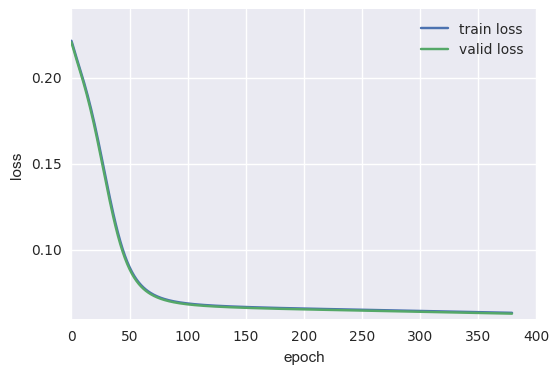

In [128]:
X = X.reshape(-1, INPUT_DIM)
X_submission = X_submission.reshape(-1, INPUT_DIM)

from lasagne.nonlinearities import sigmoid, rectify

# encoder = NeuralNet(
#     layers=[  # three layers: one hidden layer
#         ('input', layers.InputLayer),
#         ('hidden', layers.DenseLayer),
#         ('hidden2', layers.DenseLayer),
#         ('hidden', layers.DenseLayer),
#         ('output', layers.DenseLayer),
#         ],
    
#     # layer parameters:
#     input_shape=(None, INPUT_DIM),  # 410 input features per batch
#     hidden_num_units=200,  # number of units in hidden layer
#     hidden2_num_units=100,  # number of units in hidden layer
#     output_nonlinearity=None,  # output layer uses identity function
#     output_num_units=INPUT_DIM,  # 1 target values

#     update_learning_rate=theano.shared(float32(0.01)),
#     update_momentum=theano.shared(float32(0.9)),

#     # optimization method:
#     on_epoch_finished=[
#         AdjustVariable('update_learning_rate', start=0.007, stop=0.0001),
#         AdjustVariable('update_momentum', start=0.9, stop=0.999),
#         EarlyStopping(patience=100),
#         ],

#     regression=True,  # flag to indicate we're dealing with regression problem
#     max_epochs=150,  # we want to train this many epochs
#     verbose=1,
#     )

encoder2 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('encode', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    # layer parameters:
    input_shape=(None, INPUT_DIM),  # 410 input features per batch
    encode_num_units=100,  # number of units in hidden layer

    output_nonlinearity=sigmoid,  # output layer uses identity function
#     output_nonlinearity=rectify,  # output layer uses identity function
    output_num_units=INPUT_DIM,  # 1 target values

    update_learning_rate=theano.shared(float32(0.01)),
    update_momentum=theano.shared(float32(0.9)),

    # optimization method:
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.007, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=100),
        ],

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=380,  # we want to train this many epochs
    verbose=1,
    )

encoder = encoder2

encoder.fit(X, X)
cleaned_X = encoder.predict(X)

# y_submission = numpy.expm1(preds).flatten()
print y_submission.shape
# print y_submission

# computing training error
from sklearn.metrics import mean_squared_error
train_preds = encoder.predict(X)
print mean_squared_error(train_preds, X)



import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

from nolearn.lasagne.visualize import plot_loss
plot_loss(encoder)


# train_loss = np.array([i["train_loss"] for i in encoder.train_history_])
# valid_loss = np.array([i["valid_loss"] for i in encoder.train_history_])
# plt.plot(train_loss, linewidth=3, label="train")
# plt.plot(valid_loss, linewidth=3, label="valid")
# plt.grid()
# plt.legend()
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.ylim(1e-3, 1)
# plt.yscale("log")
# plt.show()

(1455, 268)
(1455, 268)
(1455, 1)
rmse lasso cv 0.110286940276
(1455, 536)
rmse lasso cv 0.110286984674
rmse with feature 268 append transformed 268 lasso 0.110286984674
(1455, 268)
rmse lasso cv 0.111013590985
rmse with feature 268 + transformed 268 lasso 0.111013590985
(2910, 268)
rmse lasso cv 0.110286940276
rmse with more data lasso 0.110286940276
(1455,)


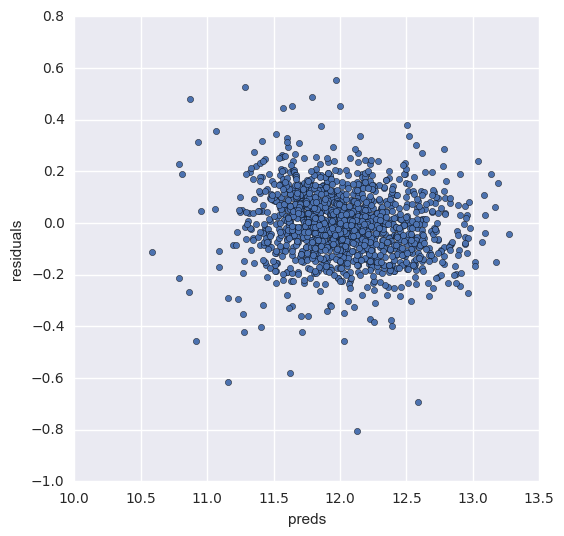

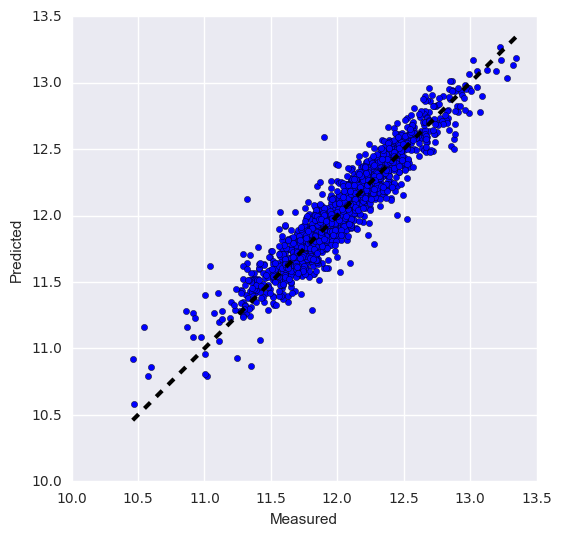

In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor



X = X.reshape(-1, INPUT_DIM)
cleaned_X = cleaned_X.reshape(-1, INPUT_DIM)
print cleaned_X.shape


# X_train = X
X_train = X.reshape(-1, INPUT_DIM)
print X_train.shape

# y = y.flatten()
print y.shape
model_lasso = LassoCV(alphas = [1,0.1, 0.001, 0.0005]).fit(X_train, y)

print "rmse lasso cv {}".format(rmse_cv(model_lasso).mean())


X_train = np.append(X,cleaned_X,axis=1)

print X_train.shape

model_lasso = LassoCV(alphas = [1,0.1, 0.001, 0.0005]).fit(X_train, y)

print "rmse lasso cv {}".format(rmse_cv(model_lasso).mean())
print "rmse with feature {} append transformed {} lasso {}".format(X.shape[1],cleaned_X.shape[1],rmse_cv(model_lasso).mean())


X_train = X + cleaned_X

print X_train.shape

model_lasso = LassoCV(alphas = [1,0.1, 0.001, 0.0005]).fit(X_train, y)

print "rmse lasso cv {}".format(rmse_cv(model_lasso).mean())
print "rmse with feature {} + transformed {} lasso {}".format(X.shape[1],cleaned_X.shape[1],rmse_cv(model_lasso).mean())


X_train = np.append(X,cleaned_X,axis=0)
y_ = np.append(y,y,axis=0)

print X_train.shape

model_lasso = LassoCV(alphas = [1,0.1, 0.001, 0.0005]).fit(X_train, y_)
X_train = X

print "rmse lasso cv {}".format(rmse_cv(model_lasso).mean())
print "rmse with more data lasso {}".format(rmse_cv(model_lasso).mean())





matplotlib.rcParams['figure.figsize'] = (6.0,6.0)

print model_lasso.predict(X_train).shape
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true": y.flatten()})



preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x= "preds", y = "residuals", kind = "scatter")


# Plotting Cross-Validated Predictions

fig, ax = plt.subplots()
ax.scatter(y, preds.preds)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()



In [122]:
# from lasagne.layers import get_output


def get_layer_by_name(net, name):
    for i, layer in enumerate(net.get_all_layers()):
        if layer.name == name:
            return layer, i
    return None, None

def encode_input(encode_layer, X):
    return layers.get_output(encode_layer, inputs=X).eval()
    
import lasagne

encode_layer, encode_layer_index = get_layer_by_name(encoder, 'encode')
print encode_layer, encode_layer_index

X_encoded = encode_input(encode_layer, X)
print X_encoded.shape



X = X.reshape(-1, INPUT_DIM)
print X.shape
X_train = X



model_lasso = LassoCV(alphas = [1,0.1, 0.001, 0.0005]).fit(X_train, y)

train_preds = model_lasso.predict(X_train)
print "training error", mean_squared_error(train_preds, y)

# print "{} attributes".format(X_train.shape[1])
print "rmse with original feature {} lasso {}".format(X.shape[1], rmse_cv(model_lasso).mean())

X_train = X_encoded
model_lasso = LassoCV(alphas = [1,0.1, 0.001, 0.0005]).fit(X_train, y)

train_preds = model_lasso.predict(X_train)
print "training error", mean_squared_error(train_preds, y)
# print "{} attributes".format(X_train.shape[1])
print "rmse with encoded feature {} lasso {}".format(X_encoded.shape[1],rmse_cv(model_lasso).mean())


X_train = np.append(X,X_encoded,axis=1)

model_lasso = LassoCV(alphas = [1,0.1, 0.001, 0.0005]).fit(X_train, y)
train_preds = model_lasso.predict(X_train)
print "training error", mean_squared_error(train_preds, y)
# print "{} attributes".format(X_train.shape[1])
print "rmse with feature {} + encoded {} lasso {}".format(X.shape[1],X_encoded.shape[1],rmse_cv(model_lasso).mean())


<lasagne.layers.dense.DenseLayer object at 0x10e553b50> 1
(1455, 100)
(1455, 268)
training error 0.0098768
rmse with original feature 268 lasso 0.110286940276
training error 0.0268855
rmse with encoded feature 100 lasso 0.174304327616
training error 0.00983781
rmse with feature 268 + encoded 100 lasso 0.110740344134
